# Import thư viện

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import os
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

print("Import success!!!")

Import success!!!


In [3]:
!nvidia-smi

Tue Oct 14 10:40:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load data

In [5]:
url_train = "/kaggle/input/chest-x-ray-images-normal-and-pneumonia/chest_xray/train"
url_test = "/kaggle/input/chest-x-ray-images-normal-and-pneumonia/chest_xray/test"
url_val = "/kaggle/input/chest-x-ray-images-normal-and-pneumonia/chest_xray/val"

print("Đường dẫn đến tập train:", url_train)
print("Đường dẫn đến tập test:", url_test)
print("Đường dẫn đến tập val:", url_val)

Đường dẫn đến tập train: /kaggle/input/chest-x-ray-images-normal-and-pneumonia/chest_xray/train
Đường dẫn đến tập test: /kaggle/input/chest-x-ray-images-normal-and-pneumonia/chest_xray/test
Đường dẫn đến tập val: /kaggle/input/chest-x-ray-images-normal-and-pneumonia/chest_xray/val


In [7]:
# Đếm số lượng ảnh trong mỗi thư mục con (NORMAL/PNEUMONIA) của từng tập dữ liệu

# Tập Train
num_normal_train = len(os.listdir(os.path.join(url_train, 'NORMAL')))
num_pneumonia_train = len(os.listdir(os.path.join(url_train, 'PNEUMONIA')))

# Tập Test
num_normal_test = len(os.listdir(os.path.join(url_test, 'NORMAL')))
num_pneumonia_test = len(os.listdir(os.path.join(url_test, 'PNEUMONIA')))

# Tập Val
num_normal_val = len(os.listdir(os.path.join(url_val, 'NORMAL')))
num_pneumonia_val = len(os.listdir(os.path.join(url_val, 'PNEUMONIA')))


print("--- Tập Huấn Luyện (Train) ---")
print(f"Số ảnh NORMAL: {num_normal_train}")
print(f"Số ảnh PNEUMONIA: {num_pneumonia_train}")
print("-" * 20)
print("--- Tập Kiểm Tra (Test) ---")
print(f"Số ảnh NORMAL: {num_normal_test}")
print(f"Số ảnh PNEUMONIA: {num_pneumonia_test}")
print("-" * 20)
print("--- Tập Kiểm Định (Validation) ---")
print(f"Số ảnh NORMAL: {num_normal_val}")
print(f"Số ảnh PNEUMONIA: {num_pneumonia_val}")

--- Tập Huấn Luyện (Train) ---
Số ảnh NORMAL: 1341
Số ảnh PNEUMONIA: 3875
--------------------
--- Tập Kiểm Tra (Test) ---
Số ảnh NORMAL: 234
Số ảnh PNEUMONIA: 390
--------------------
--- Tập Kiểm Định (Validation) ---
Số ảnh NORMAL: 24
Số ảnh PNEUMONIA: 23


In [8]:
url = "/kaggle/input/chest-x-ray-images-normal-and-pneumonia/chest_xray/train"

data = []
for root, dirs, files in os.walk(url):
    for file in files:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            label = os.path.basename(root)  # tên thư mục là nhãn
            data.append({
                'filepath': os.path.join(root, file),
                'label': label
            })
    
df = pd.DataFrame(data)
print(df['label'].value_counts())


label
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64


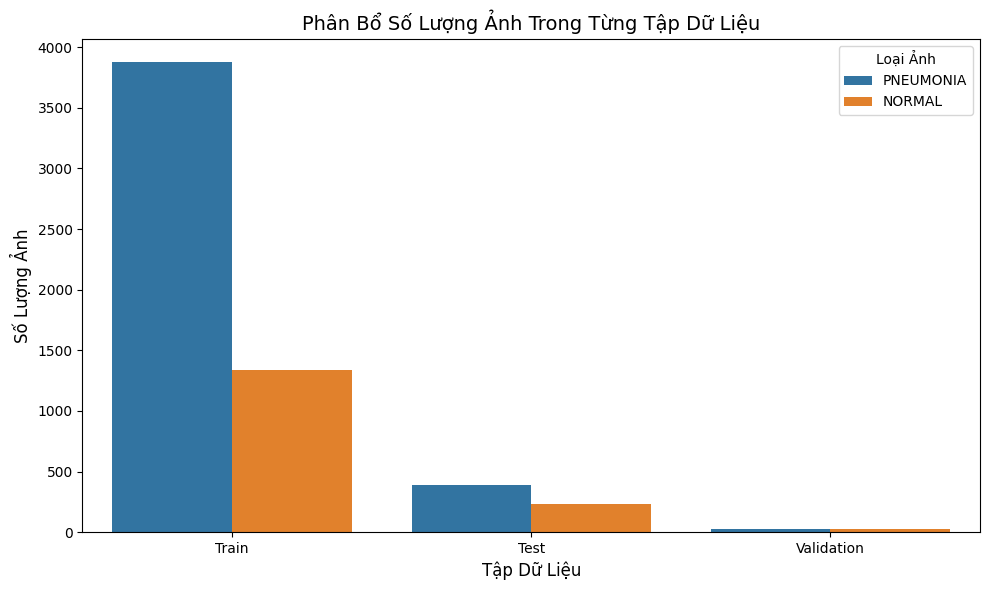

In [9]:
# --- Tạo DataFrame để vẽ biểu đồ ---
data_counts = {
    'Tập Dữ Liệu': [
        'Train', 'Train', 
        'Test', 'Test', 
        'Validation', 'Validation'
    ],
    'Lớp': [
        'PNEUMONIA', 'NORMAL',
        'PNEUMONIA', 'NORMAL',
        'PNEUMONIA', 'NORMAL'
    ],
    'Số Lượng': [
        num_pneumonia_train, num_normal_train,
        num_pneumonia_test, num_normal_test,
        num_pneumonia_val, num_normal_val
    ]
}

df_counts = pd.DataFrame(data_counts)

# --- Vẽ biểu đồ ---
plt.figure(figsize=(10, 6))
sns.barplot(x='Tập Dữ Liệu', y='Số Lượng', hue='Lớp', data=df_counts)

plt.title('Phân Bổ Số Lượng Ảnh Trong Từng Tập Dữ Liệu', fontsize=14)
plt.xlabel('Tập Dữ Liệu', fontsize=12)
plt.ylabel('Số Lượng Ảnh', fontsize=12)
plt.legend(title='Loại Ảnh')
plt.tight_layout()
plt.show()

Các ảnh mẫu của lớp NORMAL:


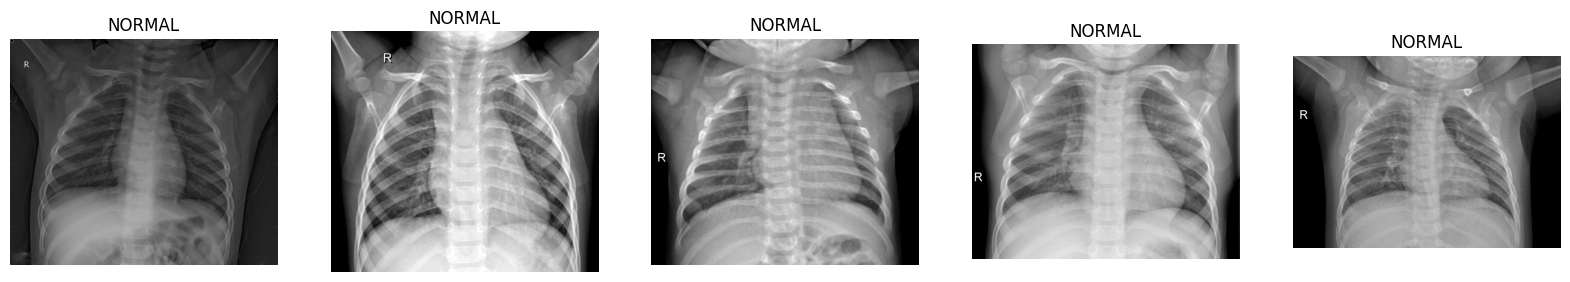


Các ảnh mẫu của lớp PNEUMONIA:


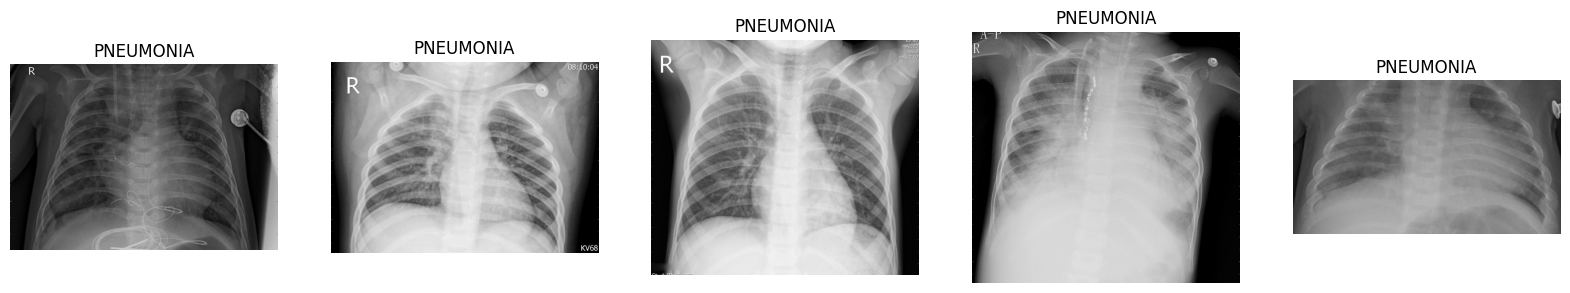

In [10]:
# Lấy danh sách 5 ảnh đầu tiên từ mỗi loại trong tập train
normal_images = os.listdir(os.path.join(url_train, 'NORMAL'))[:5]
pneumonia_images = os.listdir(os.path.join(url_train, 'PNEUMONIA'))[:5]

# --- Hiển thị ảnh NORMAL ---
print("Các ảnh mẫu của lớp NORMAL:")
fig, axes = plt.subplots(1, 5, figsize=(20, 4)) # Tạo một hàng gồm 5 cột để vẽ ảnh
for i, img_name in enumerate(normal_images):
    img_path = os.path.join(url_train, 'NORMAL', img_name)
    img = plt.imread(img_path) # Đọc file ảnh
    axes[i].imshow(img, cmap='gray') # Hiển thị ảnh, cmap='gray' để hiển thị đúng ảnh x-quang
    axes[i].set_title('NORMAL')
    axes[i].axis('off') # Ẩn các trục tọa độ
plt.show()

# --- Hiển thị ảnh PNEUMONIA ---
print("\nCác ảnh mẫu của lớp PNEUMONIA:")
fig, axes = plt.subplots(1, 5, figsize=(20, 4)) # Tạo một hàng khác
for i, img_name in enumerate(pneumonia_images):
    img_path = os.path.join(url_train, 'PNEUMONIA', img_name)
    img = plt.imread(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title('PNEUMONIA')
    axes[i].axis('off')
plt.show()

# Mô hình CNN tự build

In [11]:
# Tạo một generator cho tập huấn luyện với Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Chuẩn hóa giá trị pixel về khoảng 
    shear_range=0.2,         # Biến dạng ảnh (cắt xén) một cách ngẫu nhiên
    zoom_range=0.2,          # Phóng to ảnh một cách ngẫu nhiên
    horizontal_flip=True     # Lật ngang ảnh một cách ngẫu nhiên
)

# Tạo một generator cho tập kiểm tra và kiểm định (chỉ chuẩn hóa)
test_datagen = ImageDataGenerator(rescale=1./255)

# Thiết lập các thông số chung
IMG_SIZE = (150, 150) # Kích thước ảnh tiêu chuẩn
BATCH_SIZE = 32       # Số lượng ảnh trong mỗi lô dữ liệu

# Tạo các bộ dữ liệu (dataset) từ các thư mục
training_set = train_datagen.flow_from_directory(
    url_train,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_set = test_datagen.flow_from_directory(
    url_val,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_set = test_datagen.flow_from_directory(
    url_test,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
# Khởi tạo mô hình Sequential
model = Sequential()

# --- Tầng 1: Lớp tích chập đầu tiên ---
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- Tầng 2: Lớp tích chập thứ hai ---
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- Tầng 3: Lớp tích chập thứ ba ---
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- Giai đoạn phân loại ---
model.add(Flatten()) # Làm phẳng dữ liệu
model.add(Dense(512, activation='relu')) # Lớp ẩn với 512 nơ-ron
model.add(Dense(1, activation='sigmoid')) # Lớp đầu ra
model.summary()

I0000 00:00:1760386695.712301      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [14]:
# Bắt đầu huấn luyện mô hình
# Chúng ta sẽ lưu lại lịch sử quá trình huấn luyện vào biến 'history'
history = model.fit(
  training_set,
  epochs=10,
  validation_data=validation_set
)

Epoch 1/10


I0000 00:00:1760386715.441669     135 service.cc:148] XLA service 0x792258004060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760386715.442439     135 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760386715.812621     135 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/163 ━━━━━━━━━━━━━━━━━━━━ 15:31 6s/step - accuracy: 0.6250 - loss: 0.6857

I0000 00:00:1760386718.498084     135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 501ms/step - accuracy: 0.7795 - loss: 0.5278 - val_accuracy: 0.8511 - val_loss: 0.4125
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 384ms/step - accuracy: 0.9048 - loss: 0.2384 - val_accuracy: 0.7234 - val_loss: 0.6412
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 382ms/step - accuracy: 0.9134 - loss: 0.2142 - val_accuracy: 0.7660 - val_loss: 0.4197
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 381ms/step - accuracy: 0.9201 - loss: 0.1994 - val_accuracy: 0.9574 - val_loss: 0.2212
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 381ms/step - accuracy: 0.9358 - loss: 0.1660 - val_accuracy: 0.8723 - val_loss: 0.3070
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 380ms/step - accuracy: 0.9442 - loss: 0.1441 - val_accuracy: 0.8085 - val_loss: 0.3113
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 385ms/step - accuracy: 0.9541 - loss: 0.1329 - val_accuracy: 0.7234 - val_loss: 0.7011
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 383ms/step - accuracy: 0.9505 - loss: 0.1302 - val

**Tái Cấu Trúc Dữ Liệu - Xây Dựng Một Sân Chơi Công Bằng**

Mục tiêu của bước này:

Bỏ qua hoàn toàn thư mục val gốc (với 16 ảnh).

Lấy toàn bộ dữ liệu từ thư mục train gốc (5216 ảnh) và chia nó một cách khoa học thành một tập huấn luyện mới (khoảng 80%) và một tập kiểm định mới (khoảng 20%).

Đảm bảo rằng tỷ lệ ảnh NORMAL và PNEUMONIA trong tập huấn luyện mới và tập kiểm định mới là tương đương nhau.

In [23]:
# Lấy đường dẫn đến 2 thư mục con
normal_dir = os.path.join(url_train, 'NORMAL')
pneumonia_dir = os.path.join(url_train, 'PNEUMONIA')

# Lấy danh sách file
normal_files = os.listdir(normal_dir)
pneumonia_files = os.listdir(pneumonia_dir)

# Tạo danh sách đầy đủ đường dẫn và nhãn
all_filepaths = []
all_labels = []

for f in normal_files:
    all_filepaths.append(os.path.join(normal_dir, f))
    all_labels.append('NORMAL')

for f in pneumonia_files:
    all_filepaths.append(os.path.join(pneumonia_dir, f))
    all_labels.append('PNEUMONIA')

print(f"Tổng số ảnh để chia: {len(all_filepaths)}")
print(f"Tổng số nhãn tương ứng: {len(all_labels)}")


Tổng số ảnh để chia: 5216
Tổng số nhãn tương ứng: 5216


In [24]:
# Chia dữ liệu thành 80% train và 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    all_filepaths,
    all_labels,
    test_size=0.2,
    random_state=42,
    stratify=all_labels
)

print(f"Số lượng ảnh trong tập train mới: {len(X_train)}")
print(f"Số lượng ảnh trong tập validation mới: {len(X_val)}")

Số lượng ảnh trong tập train mới: 4172
Số lượng ảnh trong tập validation mới: 1044


In [25]:
# Tạo DataFrame cho tập train và validation mới
train_df = pd.DataFrame({'filepath': X_train, 'label': y_train})
val_df = pd.DataFrame({'filepath': X_val, 'label': y_val})

print("--- Phân bổ tập Train mới ---")
print(train_df['label'].value_counts())
print("\n--- Phân bổ tập Validation mới ---")
print(val_df['label'].value_counts())

# --- CẬP NHẬT CÁCH TẠO BỘ DỮ LIỆU ---
# Các generator train_datagen và test_datagen vẫn giữ nguyên như cũ

training_set_new = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_set_new = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

--- Phân bổ tập Train mới ---
label
PNEUMONIA    3099
NORMAL       1073
Name: count, dtype: int64

--- Phân bổ tập Validation mới ---
label
PNEUMONIA    776
NORMAL       268
Name: count, dtype: int64
Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.


Tạo lại mô hình

In [26]:
# Khởi tạo lại một mô hình mới hoàn toàn
model_new = Sequential()

# --- Tầng 1: Lớp tích chập đầu tiên ---
model_new.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_new.add(MaxPooling2D(pool_size=(2, 2)))

# --- Tầng 2: Lớp tích chập thứ hai ---
model_new.add(Conv2D(64, (3, 3), activation='relu'))
model_new.add(MaxPooling2D(pool_size=(2, 2)))

# --- Tầng 3: Lớp tích chập thứ ba ---
model_new.add(Conv2D(128, (3, 3), activation='relu'))
model_new.add(MaxPooling2D(pool_size=(2, 2)))

# --- Giai đoạn phân loại ---
model_new.add(Flatten()) # Làm phẳng dữ liệu
model_new.add(Dense(512, activation='relu')) # Lớp ẩn với 512 nơ-ron
model_new.add(Dense(1, activation='sigmoid')) # Lớp đầu ra

# In ra tóm tắt để xác nhận
model_new.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model_new.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [28]:
# Bắt đầu huấn luyện mô hình trên dữ liệu mới
history_new = model_new.fit(
  training_set_new,
  epochs=10,
  validation_data=validation_set_new
)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 62s 453ms/step - accuracy: 0.7374 - loss: 0.6158 - val_accuracy: 0.9253 - val_loss: 0.1903
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 438ms/step - accuracy: 0.8944 - loss: 0.2480 - val_accuracy: 0.9004 - val_loss: 0.2409
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 435ms/step - accuracy: 0.9145 - loss: 0.2193 - val_accuracy: 0.9368 - val_loss: 0.1467
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 438ms/step - accuracy: 0.9340 - loss: 0.1766 - val_accuracy: 0.9444 - val_loss: 0.1367
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 435ms/step - accuracy: 0.9293 - loss: 0.1795 - val_accuracy: 0.9473 - val_loss: 0.1339
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 434ms/step - accuracy: 0.9452 - loss: 0.1453 - val_accuracy: 0.9080 - val_loss: 0.2578
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 434ms/step - accuracy: 0.9249 - loss: 0.1697 - val_accuracy: 0.9473 - val_loss: 0.1447
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 432ms/step - accuracy: 0.9511 - loss: 0

Trực quan hóa lịch sử huấn luyện

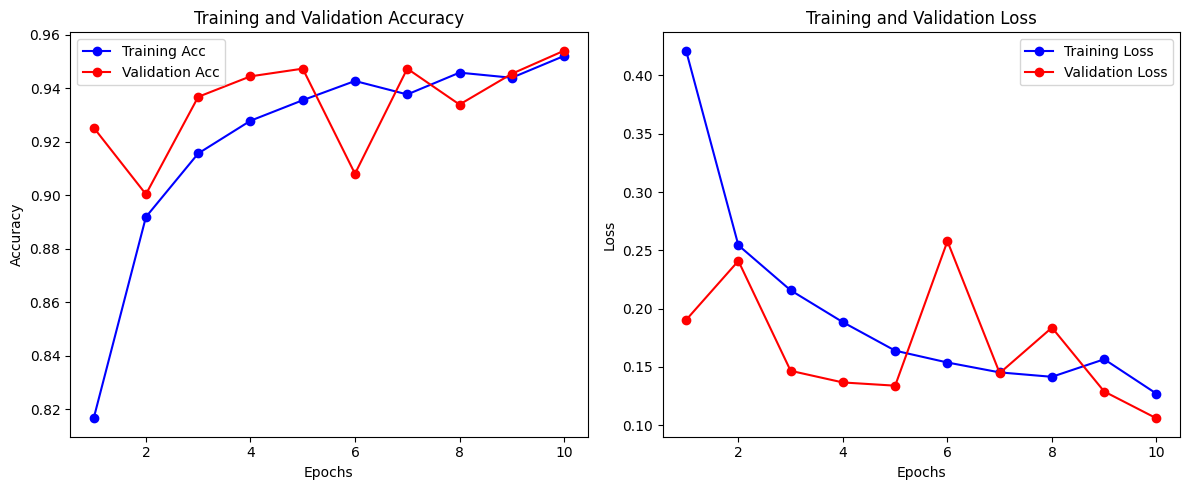

In [29]:
# Lấy các giá trị từ đối tượng history_new
acc = history_new.history['accuracy']
val_acc = history_new.history['val_accuracy']
loss = history_new.history['loss']
val_loss = history_new.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Vẽ biểu đồ Độ chính xác (Accuracy)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Training Acc')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vẽ biểu đồ Mất mát (Loss)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout() # Tự động điều chỉnh để các biểu đồ không bị đè lên nhau
plt.show()

In [30]:
# Đánh giá mô hình trên tập test
test_loss, test_accuracy = model_new.evaluate(test_set)

print(f"Độ chính xác trên tập Test: {test_accuracy * 100:.2f}%")
print(f"Mất mát trên tập Test: {test_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.9020 - loss: 0.3506
Độ chính xác trên tập Test: 90.06%
Mất mát trên tập Test: 0.3411


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step


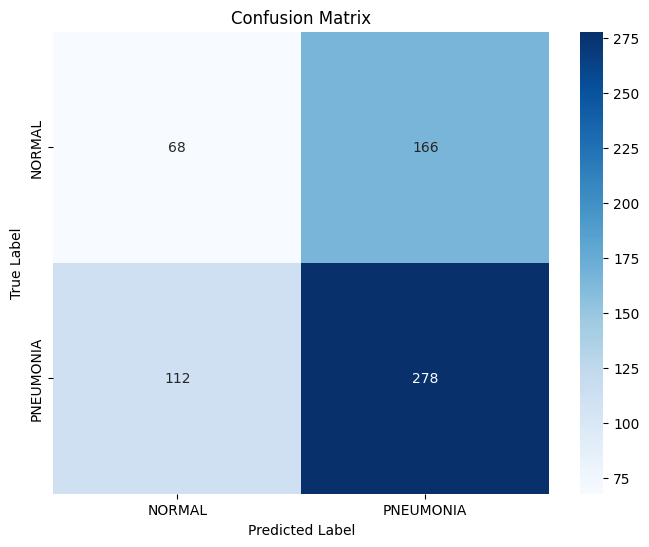


Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.38      0.29      0.33       234
   PNEUMONIA       0.63      0.71      0.67       390

    accuracy                           0.55       624
   macro avg       0.50      0.50      0.50       624
weighted avg       0.53      0.55      0.54       624



In [46]:
# Lấy tất cả các nhãn thực tế từ test_set
# Lưu ý: test_set đã được tạo từ Bước 3, chúng ta dùng lại nó
y_true = test_set.classes

# Lấy dự đoán của mô hình trên toàn bộ test_set
# model.predict sẽ trả về xác suất, chúng ta cần chuyển nó thành 0 hoặc 1
y_pred_probs = model_new.predict(test_set)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# 1. Vẽ Ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_set.class_indices.keys(),
            yticklabels=test_set.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# In ra Báo cáo phân loại chi tiết
print("\nClassification Report:\n")
# test_set.class_indices sẽ cho chúng ta biết lớp nào là 0, lớp nào là 1
print(classification_report(y_true, y_pred, target_names=test_set.class_indices.keys()))

In [33]:
# Tạo lại test_set với shuffle=False để đảm bảo thứ tự
test_set_final = test_datagen.flow_from_directory(
    url_test,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Đây là thay đổi quan trọng nhất!
)

Found 624 images belonging to 2 classes.


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step


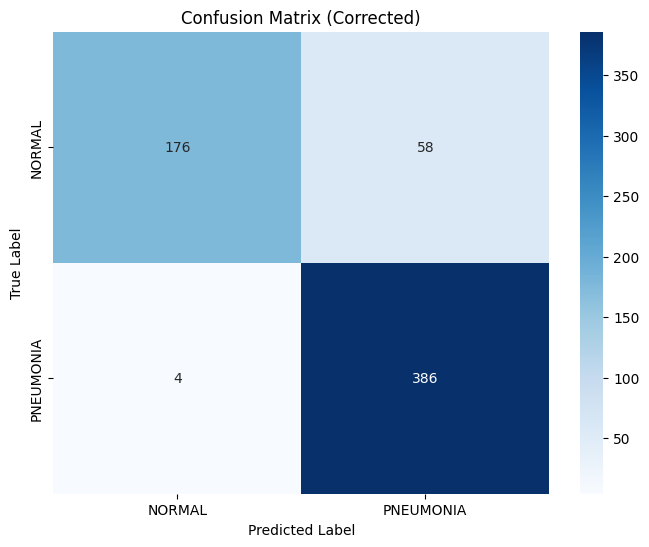


Classification Report (Corrected):

              precision    recall  f1-score   support

      NORMAL       0.98      0.75      0.85       234
   PNEUMONIA       0.87      0.99      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624



In [34]:
# Lấy nhãn đúng (bây giờ đã cùng thứ tự với dự đoán)
y_true_final = test_set_final.classes

# Lấy dự đoán của mô hình
y_pred_probs_final = model_new.predict(test_set_final)
y_pred_final = (y_pred_probs_final > 0.5).astype(int).flatten()

# 1. Vẽ Ma trận nhầm lẫn CHÍNH XÁC
cm_final = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_set_final.class_indices.keys(),
            yticklabels=test_set_final.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Corrected)')
plt.show()

# In ra Báo cáo phân loại CHÍNH XÁC
print("\nClassification Report (Corrected):\n")
print(classification_report(y_true_final, y_pred_final, target_names=test_set_final.class_indices.keys()))

Lưu mô hình

In [35]:
# Định nghĩa tên file để lưu mô hình
# Định dạng.keras là định dạng tiêu chuẩn và được khuyến nghị hiện nay
model_filename = 'pneumonia_cnn_model.keras'

# Sử dụng lệnh save để lưu mô hình
model_new.save(model_filename)

print(f"Mô hình đã được lưu thành công vào file: {model_filename}")
print("Bạn có thể tìm thấy file này trong bảng 'Data' ở bên phải, dưới mục 'Output'.")

Mô hình đã được lưu thành công vào file: pneumonia_cnn_model.keras
Bạn có thể tìm thấy file này trong bảng 'Data' ở bên phải, dưới mục 'Output'.


# Traing mô hình với Transfer learning

## DenseNet121

In [46]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS_STAGE1 = 20
EPOCHS_STAGE2 = 20

In [47]:
# Lấy file từ thư mục train
normal_dir = os.path.join(url_train, "NORMAL")
pneumonia_dir = os.path.join(url_train, "PNEUMONIA")

normal_files = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir)]
pneumonia_files = [os.path.join(pneumonia_dir, f) for f in os.listdir(pneumonia_dir)]

# Gắn nhãn cho từng ảnh
all_filepaths = normal_files + pneumonia_files
all_labels = ["NORMAL"] * len(normal_files) + ["PNEUMONIA"] * len(pneumonia_files)

# Chia train / val (80/20)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_filepaths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

# Tạo df
train_df = pd.DataFrame({'filepath': train_paths, 'label': train_labels})
val_df = pd.DataFrame({'filepath': val_paths, 'label': val_labels})

# Tạo test_df riêng từ thư mục test
normal_test = [os.path.join(url_test, "NORMAL", f) for f in os.listdir(os.path.join(url_test, "NORMAL"))]
pneumonia_test = [os.path.join(url_test, "PNEUMONIA", f) for f in os.listdir(os.path.join(url_test, "PNEUMONIA"))]
test_df = pd.DataFrame({
    'filepath': normal_test + pneumonia_test,
    'label': ['NORMAL'] * len(normal_test) + ['PNEUMONIA'] * len(pneumonia_test)
})

print("--- Train/Val/Test phân bổ ---")
print(train_df['label'].value_counts())
print(val_df['label'].value_counts())
print(test_df['label'].value_counts())


--- Train/Val/Test phân bổ ---
label
PNEUMONIA    3099
NORMAL       1073
Name: count, dtype: int64
label
PNEUMONIA    776
NORMAL       268
Name: count, dtype: int64
label
PNEUMONIA    390
NORMAL       234
Name: count, dtype: int64


In [49]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_gen = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [50]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Giai đoạn 1: đóng băng

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_10   │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_11   │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [52]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-6)
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [53]:
print("\n--- GIAI ĐOẠN 1: FEATURE EXTRACTION ---")
history1 = model.fit(
    train_gen,
    epochs=EPOCHS_STAGE1,
    validation_data=val_gen,
    callbacks=[lr_reducer, early_stopper]
)


--- GIAI ĐOẠN 1: FEATURE EXTRACTION ---
Epoch 1/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 146s 455ms/step - accuracy: 0.8491 - loss: 0.3492 - val_accuracy: 0.9310 - val_loss: 0.1690 - learning_rate: 0.0010
Epoch 2/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 91s 348ms/step - accuracy: 0.9228 - loss: 0.1879 - val_accuracy: 0.9138 - val_loss: 0.1953 - learning_rate: 0.0010
Epoch 3/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9312 - loss: 0.1703
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
261/261 ━━━━━━━━━━━━━━━━━━━━ 95s 363ms/step - accuracy: 0.9312 - loss: 0.1703 - val_accuracy: 0.9033 - val_loss: 0.2269 - learning_rate: 0.0010
Epoch 4/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 92s 352ms/step - accuracy: 0.9445 - loss: 0.1470 - val_accuracy: 0.9416 - val_loss: 0.1392 - learning_rate: 1.0000e-04
Epoch 5/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 92s 352ms/step - accuracy: 0.9495 - loss: 0.1399 - val_accuracy: 0.9368 - val_loss: 0.1507 - learning_rate: 1.0000e-04
Epoch 6/20
261/261 ━━

In [55]:
print("\n--- GIAI ĐOẠN 2: FINE-TUNING ---")
base_model.trainable = True
for layer in base_model.layers:
    if 'conv5_block' not in layer.name:  # chỉ mở lớp cuối của DenseNet
        layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_gen,
    epochs=EPOCHS_STAGE2,
    initial_epoch=history1.epoch[-1] + 1,
    validation_data=val_gen,
    callbacks=[lr_reducer, early_stopper]
)


--- GIAI ĐOẠN 2: FINE-TUNING ---
Epoch 10/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 192s 503ms/step - accuracy: 0.9657 - loss: 0.0864 - val_accuracy: 0.9368 - val_loss: 0.1585 - learning_rate: 1.0000e-05
Epoch 11/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 92s 353ms/step - accuracy: 0.9768 - loss: 0.0698 - val_accuracy: 0.9330 - val_loss: 0.1702 - learning_rate: 1.0000e-05
Epoch 12/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 93s 355ms/step - accuracy: 0.9737 - loss: 0.0759 - val_accuracy: 0.9397 - val_loss: 0.1435 - learning_rate: 1.0000e-05
Epoch 13/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 90s 345ms/step - accuracy: 0.9763 - loss: 0.0613 - val_accuracy: 0.9349 - val_loss: 0.1676 - learning_rate: 1.0000e-05
Epoch 14/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9809 - loss: 0.0553
Epoch 14: ReduceLROnPlateau reducing learning rate to 1e-06.
261/261 ━━━━━━━━━━━━━━━━━━━━ 90s 347ms/step - accuracy: 0.9809 - loss: 0.0553 - val_accuracy: 0.9243 - val_loss: 0.2062 - learning_rate: 1.0000e-05
Epoch 15/20
261/261 ━━━━━━━

In [56]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"\nĐộ chính xác trên tập test: {test_acc*100:.2f}%")
print(f"Mất mát: {test_loss:.4f}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.8401 - loss: 0.3913

Độ chính xác trên tập test: 90.22%
Mất mát: 0.2534


39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step


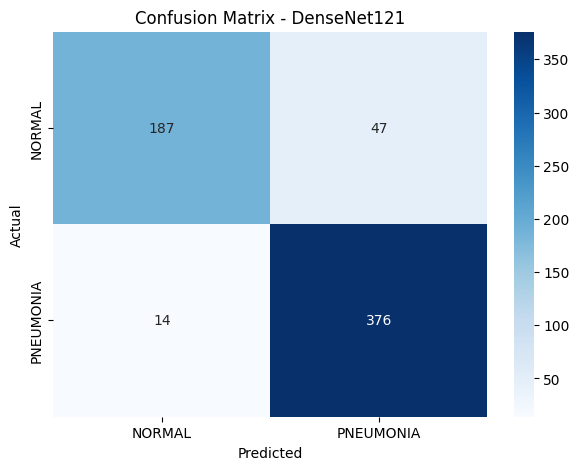


Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.93      0.80      0.86       234
   PNEUMONIA       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



In [57]:
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.title("Confusion Matrix - DenseNet121")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

In [58]:
model.save("pneumonia_densenet121.keras")
print("Model DenseNet121 đã được lưu thành công!")

Model DenseNet121 đã được lưu thành công!


## ResNet50

In [59]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 30

In [60]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.


In [61]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Đóng băng để chỉ huấn luyện phần head mới

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model_res = Model(inputs=base_model.input, outputs=predictions)

model_res.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_res.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [62]:
lr_reducer_1 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-6)
early_stopper_1 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

print("\n--- GIAI ĐOẠN 1: FEATURE EXTRACTION ---")
history1_res = model_res.fit(
    train_gen,
    epochs=EPOCHS_STAGE1,
    validation_data=val_gen,
    callbacks=[lr_reducer_1, early_stopper_1]
)


--- GIAI ĐOẠN 1: FEATURE EXTRACTION ---
Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 107s 703ms/step - accuracy: 0.8558 - loss: 0.3871 - val_accuracy: 0.9665 - val_loss: 0.1042 - learning_rate: 0.0010
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 622ms/step - accuracy: 0.9416 - loss: 0.1380 - val_accuracy: 0.9713 - val_loss: 0.0871 - learning_rate: 0.0010
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 81s 621ms/step - accuracy: 0.9482 - loss: 0.1340 - val_accuracy: 0.9004 - val_loss: 0.2716 - learning_rate: 0.0010
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.9601 - loss: 0.1021
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
131/131 ━━━━━━━━━━━━━━━━━━━━ 81s 616ms/step - accuracy: 0.9601 - loss: 0.1022 - val_accuracy: 0.9588 - val_loss: 0.1069 - learning_rate: 0.0010
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 86s 654ms/step - accuracy: 0.9626 - loss: 0.1052 - val_accuracy: 0.9464 - val_loss: 0.1448 - learning_rate: 1.0000e-04
Epoch 6/10
131/131 ━━━━━━

In [63]:
print("\n--- GIAI ĐOẠN 2: FINE-TUNING ---")

# Mở băng mô hình gốc
base_model.trainable = True

# Chỉ mở băng từ block cuối cùng (để tránh phá hỏng feature cũ)
for layer in base_model.layers:
    if 'conv5_block' not in layer.name:
        layer.trainable = False

# Compile lại với learning rate nhỏ
model_res.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# CALLBACKS MỚI CHO STAGE 2
lr_reducer_2 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-7)
early_stopper_2 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history2_res = model_res.fit(
    train_gen,
    epochs=EPOCHS_STAGE2,
    initial_epoch=history1_res.epoch[-1] + 1,
    validation_data=val_gen,
    callbacks=[lr_reducer_2, early_stopper_2]
)



--- GIAI ĐOẠN 2: FINE-TUNING ---
Epoch 8/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 121s 731ms/step - accuracy: 0.9391 - loss: 0.1741 - val_accuracy: 0.9444 - val_loss: 0.1497 - learning_rate: 1.0000e-05
Epoch 9/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 80s 613ms/step - accuracy: 0.9593 - loss: 0.1163 - val_accuracy: 0.9511 - val_loss: 0.1455 - learning_rate: 1.0000e-05
Epoch 10/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 642ms/step - accuracy: 0.9760 - loss: 0.0734 - val_accuracy: 0.9416 - val_loss: 0.1733 - learning_rate: 1.0000e-05
Epoch 11/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.9734 - loss: 0.0701
Epoch 11: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
131/131 ━━━━━━━━━━━━━━━━━━━━ 80s 612ms/step - accuracy: 0.9734 - loss: 0.0701 - val_accuracy: 0.9444 - val_loss: 0.1655 - learning_rate: 1.0000e-05
Epoch 12/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 80s 612ms/step - accuracy: 0.9838 - loss: 0.0544 - val_accuracy: 0.9454 - val_loss: 0.1635 - learning_rate: 1.0000e-06
Epoch 13/30
1

In [66]:
print("\n--- ĐÁNH GIÁ TRÊN TẬP TEST ---")

# Nếu cậu có test_set dạng flow_from_dataframe

test_gen = test_datagen.flow_from_directory(
    directory=url_test,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


test_loss, test_acc = model_res.evaluate(test_gen)
print(f"Độ chính xác trên tập Test: {test_acc * 100:.2f}%")
print(f"Độ mất mát trên tập Test: {test_loss:.4f}")


--- ĐÁNH GIÁ TRÊN TẬP TEST ---
Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 381ms/step - accuracy: 0.8540 - loss: 0.3542
Độ chính xác trên tập Test: 89.90%
Độ mất mát trên tập Test: 0.2478


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 436ms/step


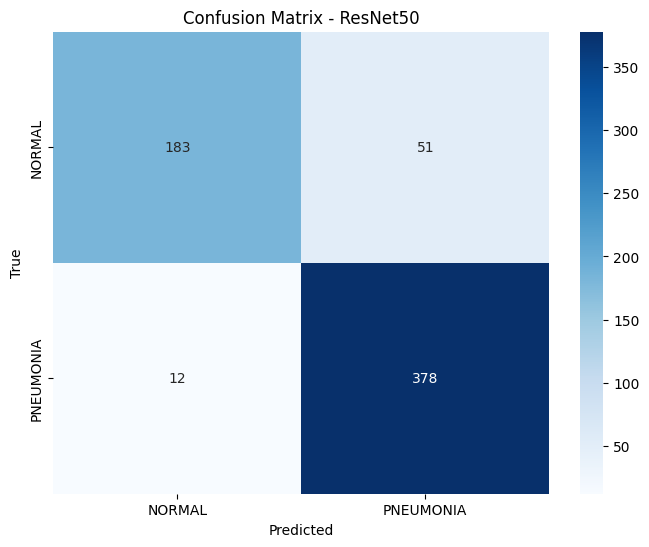


Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.94      0.78      0.85       234
   PNEUMONIA       0.88      0.97      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



In [67]:
y_true = test_gen.classes
y_pred_probs = model_res.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet50')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))


In [68]:
model_res.save("pneumonia_resnet50.keras")
print("Model Resnet50 đã được lưu thành công!")

Model Resnet50 đã được lưu thành công!


## EfficientNetB3

In [69]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

IMG_SIZE = (300, 300)      # EfficientNetB3 dùng ảnh lớn hơn
BATCH_SIZE = 16            # giảm batch vì mô hình nặng hơn
EPOCHS_STAGE1 = 8
EPOCHS_STAGE2 = 25

In [70]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.


In [71]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
base_model.trainable = False  # giai đoạn đầu chỉ huấn luyện head

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model_eff = Model(inputs=base_model.input, outputs=predictions)

model_eff.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_eff.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 11,177,264 (42.64 MB)

 Trainable params: 393,729 (1.50 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [72]:
lr_reducer_1 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-6)
early_stopper_1 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

print("\n--- GIAI ĐOẠN 1: FEATURE EXTRACTION ---")
history1_eff = model_eff.fit(
    train_gen,
    epochs=EPOCHS_STAGE1,
    validation_data=val_gen,
    callbacks=[lr_reducer_1, early_stopper_1]
)


--- GIAI ĐOẠN 1: FEATURE EXTRACTION ---
Epoch 1/8
 46/261 ━━━━━━━━━━━━━━━━━━━━ 1:21 380ms/step - accuracy: 0.8077 - loss: 0.4717

E0000 00:00:1760447696.458344     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760447696.671246     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760447696.949011     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760447697.162693     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


261/261 ━━━━━━━━━━━━━━━━━━━━ 187s 551ms/step - accuracy: 0.8749 - loss: 0.3039 - val_accuracy: 0.9301 - val_loss: 0.1698 - learning_rate: 0.0010
Epoch 2/8
261/261 ━━━━━━━━━━━━━━━━━━━━ 109s 417ms/step - accuracy: 0.9325 - loss: 0.1541 - val_accuracy: 0.9406 - val_loss: 0.1523 - learning_rate: 0.0010
Epoch 3/8
261/261 ━━━━━━━━━━━━━━━━━━━━ 108s 415ms/step - accuracy: 0.9447 - loss: 0.1365 - val_accuracy: 0.9444 - val_loss: 0.1316 - learning_rate: 0.0010
Epoch 4/8
261/261 ━━━━━━━━━━━━━━━━━━━━ 108s 415ms/step - accuracy: 0.9434 - loss: 0.1323 - val_accuracy: 0.9473 - val_loss: 0.1233 - learning_rate: 0.0010
Epoch 5/8
261/261 ━━━━━━━━━━━━━━━━━━━━ 109s 416ms/step - accuracy: 0.9481 - loss: 0.1342 - val_accuracy: 0.9617 - val_loss: 0.0969 - learning_rate: 0.0010
Epoch 6/8
261/261 ━━━━━━━━━━━━━━━━━━━━ 110s 420ms/step - accuracy: 0.9572 - loss: 0.1123 - val_accuracy: 0.9665 - val_loss: 0.0874 - learning_rate: 0.0010
Epoch 7/8
261/261 ━━━━━━━━━━━━━━━━━━━━ 112s 431ms/step - accuracy: 0.9576 - loss

In [73]:
print("\n--- GIAI ĐOẠN 2: FINE-TUNING ---")

base_model.trainable = True

# Chỉ mở băng phần cuối của EfficientNetB3
fine_tune_from = 400  # giữ lại khoảng 400 lớp đầu, chỉ fine-tune phần sau
for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False

model_eff.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

lr_reducer_2 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-7)
early_stopper_2 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history2_eff = model_eff.fit(
    train_gen,
    epochs=EPOCHS_STAGE2,
    initial_epoch=history1_eff.epoch[-1] + 1,
    validation_data=val_gen,
    callbacks=[lr_reducer_2, early_stopper_2]
)


--- GIAI ĐOẠN 2: FINE-TUNING ---
Epoch 9/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 183s 538ms/step - accuracy: 0.9526 - loss: 0.1243 - val_accuracy: 0.9598 - val_loss: 0.0999 - learning_rate: 1.0000e-05
Epoch 10/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 112s 428ms/step - accuracy: 0.9581 - loss: 0.1068 - val_accuracy: 0.9531 - val_loss: 0.1078 - learning_rate: 1.0000e-05
Epoch 11/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9512 - loss: 0.1122
Epoch 11: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
261/261 ━━━━━━━━━━━━━━━━━━━━ 112s 430ms/step - accuracy: 0.9512 - loss: 0.1122 - val_accuracy: 0.9531 - val_loss: 0.1106 - learning_rate: 1.0000e-05
Epoch 12/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 112s 428ms/step - accuracy: 0.9628 - loss: 0.1077 - val_accuracy: 0.9531 - val_loss: 0.1101 - learning_rate: 1.0000e-06
Epoch 13/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9607 - loss: 0.1096
Epoch 13: ReduceLROnPlateau reducing learning rate to 1e-07.
261/261 ━━━━━━━━━━━

In [75]:
print("\n--- ĐÁNH GIÁ TRÊN TẬP TEST ---")

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_directory(
    directory=url_test,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


test_loss, test_acc = model_eff.evaluate(test_gen)
print(f"Độ chính xác trên tập Test: {test_acc * 100:.2f}%")
print(f"Độ mất mát trên tập Test: {test_loss:.4f}")



--- ĐÁNH GIÁ TRÊN TẬP TEST ---
Found 624 images belonging to 2 classes.
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.8228 - loss: 0.5536
Độ chính xác trên tập Test: 88.94%
Độ mất mát trên tập Test: 0.3334


39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step


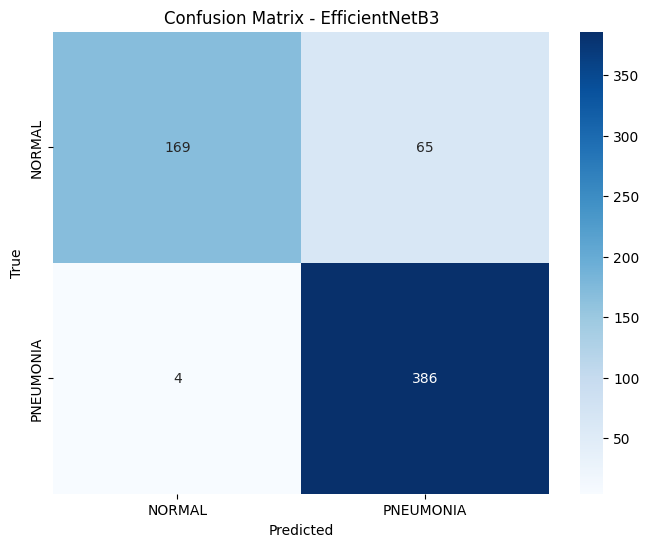


Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.98      0.72      0.83       234
   PNEUMONIA       0.86      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.92      0.86      0.87       624
weighted avg       0.90      0.89      0.89       624



In [76]:
y_true = test_gen.classes
y_pred_probs = model_eff.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - EfficientNetB3')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

In [78]:
model_eff.save("EfficientNetB3.keras")
print("Model EfficientNetB3 đã được lưu thành công!")

Model EfficientNetB3 đã được lưu thành công!
